# Import libraries and data 

In [1]:
# PICKLING
import pickle

# DF'S, MATHS AND PLOTTING
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# MODELLING
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
sampled_species = pd.read_pickle('../Data/sampled_species_pickle')
sampled_species.reset_index(drop = True, inplace = True)

In [5]:
sampled_species.head()

,image,species,individual_id,family,genus,img_array
0,20c1a079f7f24d.jpg,melon_headed_whale,ba8e231445cd,Delphinidae,Peponocephala,"[[[202, 255, 54], [206, 255, 50], [214, 255, 4..."
1,d77088a2a5b618.jpg,melon_headed_whale,d27efa233336,Delphinidae,Peponocephala,"[[[246, 255, 10], [255, 248, 0], [255, 248, 0]..."
2,89ca19c54366f5.jpg,melon_headed_whale,adac6f755888,Delphinidae,Peponocephala,"[[[0, 184, 255], [0, 184, 255], [0, 188, 255],..."
3,dd0ae4014a02ce.jpg,melon_headed_whale,55beece99391,Delphinidae,Peponocephala,"[[[174, 255, 82], [174, 255, 82], [178, 255, 7..."
4,6d71d19da6279e.jpg,melon_headed_whale,9e94c20b6c0a,Delphinidae,Peponocephala,"[[[6, 255, 250], [10, 255, 246], [14, 255, 242..."


# Useful functions 

In [6]:
def plot_learning_curves(model_history, validation = False):
    
    """
    Plot accuracy and loss through training epochs, with or without a validation set
    """
    
    df = pd.DataFrame(model_history.history)
    df['epoch'] = range(len(df))

    fig, ax = plt.subplots(1, 2, figsize = (10,4))
    plt.suptitle('Learning curves')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')

    if validation == False:
        sns.lineplot(data = df['accuracy'], ax = ax[0])
        sns.lineplot(data = df['loss'], ax = ax[1])
    else:
        sns.lineplot(data = df[['accuracy', 'val_accuracy']], ax = ax[0])
        ax[0].legend(['training', 'validation'])
        
        sns.lineplot(data = df[['loss', 'val_loss']], ax = ax[1])
        ax[1].legend(['training', 'validation'])
        
    return

def find_family(pred, enc):
    
    """
    Decode a family using a specific encoder instantiation from a list of probabilities. 
    The highest probability will be the assigned family.
    """
    
    key = list(pred).index(pred.max())
    fam = enc[key]
    
    return fam

def decode(predictions, enc):
    
    """Decode a list of families from a specific encoder instatiation"""
    
    fams = []
    for row in predictions:
        fams.append(find_family(row, enc))
    
    return fams

def find_max(pred):
    """
    Find max probability from preditions
    """
    int_pred = []
    for row in pred:
        int_pred.append(list(row).index(row.max()))
    return int_pred

def full_classification_report(X_tr, X_te, y_tr, y_te, model):
    
    """
    Produce trian and test evaluation metrics of a model
    """
    
    # Train
    y_pred_train = model.predict(X_tr)
    print('###################### TRAIN SET ######################\n\n', 
          classification_report(y_tr, find_max(y_pred_train)), '\n\n')

    # Test
    y_pred = model.predict(X_te)
    print('###################### TEST SET ######################\n\n', 
          classification_report(y_te, find_max(y_pred)))
    
    return

def model_evaluate(model, history, X_tr, X_te, y_tr, y_te, val = False):
    
    """
    Plot learning curves and the full classification report of a model given training, test and optionally validation data
    """
    
    plot_learning_curves(history, validation = val)
    full_classification_report(X_tr, X_te, y_tr, y_te, model)
    
    return

# Check data 

In [11]:
sampled_species.isnull().sum()
# no nulls

image            0
species          0
individual_id    0
family           0
genus            0
img_array        0
dtype: int64

In [12]:
features = sampled_species.columns
sampled_species[sampled_species[features[:-1]].duplicated()]
# no duplicates

,image,species,individual_id,family,genus,img_array


In [13]:
sampled_species.dtypes

image            object
species          object
individual_id    object
family           object
genus            object
img_array        object
dtype: object

# Modelling
## Split and feature engineer

In [14]:
sampled_species['species'].value_counts(normalize=True)
# no stratification necessary

melon_headed_whale          0.05
humpback_whale              0.05
white_sided_dolphin         0.05
spotted_dolphin             0.05
cuviers_beaked_whale        0.05
spinner_dolphin             0.05
sei_whale                   0.05
long_finned_pilot_whale     0.05
dusky_dolphin               0.05
killer_whale                0.05
common_dolphin              0.05
southern_right_whale        0.05
gray_whale                  0.05
blue_whale                  0.05
fin_whale                   0.05
minke_whale                 0.05
beluga                      0.05
bottlenose_dolphin          0.05
false_killer_whale          0.05
short_finned_pilot_whale    0.05
Name: species, dtype: float64

In [15]:
# number of unique species
len(sampled_species['species'].unique())

20

In [17]:
X = []
for elem in sampled_species['img_array']:
    X.append(elem)
    
X = np.array(X, dtype = 'float')
y = sampled_species['species'].copy()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
print(X_train.shape, X_test.shape) # check shape of image arrays
print(y_train.shape, y_test.shape)

# 356x356 in pixels with 3 channels (RGB)

(3200, 356, 356, 3) (800, 356, 356, 3)
(3200,) (800,)


In [19]:
lab_enc = LabelEncoder().fit(y_train)

y_train = lab_enc.transform(y_train)
y_test = lab_enc.transform(y_test)

lab_enc_map = {i: l for i, l in enumerate(lab_enc.classes_)}

In [20]:
lab_enc_map

{0: 'beluga',
 1: 'blue_whale',
 2: 'bottlenose_dolphin',
 3: 'common_dolphin',
 4: 'cuviers_beaked_whale',
 5: 'dusky_dolphin',
 6: 'false_killer_whale',
 7: 'fin_whale',
 8: 'gray_whale',
 9: 'humpback_whale',
 10: 'killer_whale',
 11: 'long_finned_pilot_whale',
 12: 'melon_headed_whale',
 13: 'minke_whale',
 14: 'sei_whale',
 15: 'short_finned_pilot_whale',
 16: 'southern_right_whale',
 17: 'spinner_dolphin',
 18: 'spotted_dolphin',
 19: 'white_sided_dolphin'}

In [21]:
# normalise image arrays
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

In [22]:
X_train_norm[0] # check X

array([[[0.        , 0.8       , 1.        ],
        [0.        , 0.75294118, 1.        ],
        [0.        , 0.72156863, 1.        ],
        ...,
        [0.        , 0.95686275, 1.        ],
        [0.        , 0.98823529, 1.        ],
        [0.00392157, 1.        , 0.99607843]],

       [[0.        , 0.94117647, 1.        ],
        [0.        , 0.87843137, 1.        ],
        [0.        , 0.83137255, 1.        ],
        ...,
        [0.        , 0.87843137, 1.        ],
        [0.        , 0.90980392, 1.        ],
        [0.        , 0.94117647, 1.        ]],

       [[0.        , 0.90980392, 1.        ],
        [0.        , 0.8627451 , 1.        ],
        [0.        , 0.8       , 1.        ],
        ...,
        [0.        , 0.72156863, 1.        ],
        [0.        , 0.75294118, 1.        ],
        [0.        , 0.78431373, 1.        ]],

       ...,

       [[0.3372549 , 1.        , 0.66666667],
        [0.36862745, 1.        , 0.63529412],
        [0.38431373, 1

In [25]:
y_train[:10] # check y

array([11,  2,  8,  0,  5, 11, 14, 10, 19, 11])

In [24]:
pd.Series(y_train).value_counts(normalize = True) # classes are balanced, because input data is balanced before split

0     0.052500
16    0.051875
1     0.051562
10    0.051562
13    0.051562
6     0.051250
12    0.051250
8     0.050937
15    0.050313
19    0.049688
2     0.049688
14    0.049375
7     0.049063
18    0.049063
5     0.049063
9     0.048750
11    0.048750
17    0.048438
4     0.047813
3     0.047500
dtype: float64

## Artificial Neural Network 

In [26]:
ann = models.Sequential([
        layers.Flatten(input_shape=(356,356,3)),
        layers.Dense(300, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(20, activation='softmax')    
    ])

ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann_hist = ann.fit(X_train_norm, y_train, epochs = 5)

Epoch 1/5
100/100 [==============================] - 43s 377ms/step - loss: 6.6952 - accuracy: 0.0491
Epoch 2/5
100/100 [==============================] - 38s 381ms/step - loss: 2.9329 - accuracy: 0.0828
Epoch 3/5
100/100 [==============================] - 35s 348ms/step - loss: 2.8989 - accuracy: 0.0753
Epoch 4/5
100/100 [==============================] - 35s 351ms/step - loss: 2.8877 - accuracy: 0.0819
Epoch 5/5
100/100 [==============================] - 35s 355ms/step - loss: 2.8727 - accuracy: 0.0862


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###################### TRAIN SET ######################

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       168
           1       0.05      0.04      0.04       165
           2       0.07      0.01      0.01       159
           3       0.00      0.00      0.00       152
           4       0.07      0.02      0.03       153
           5       0.00      0.00      0.00       157
           6       0.07      0.84      0.13       164
           7       0.11      0.03      0.05       157
           8       0.00      0.00      0.00       163
           9       0.00      0.00      0.00       156
          10       0.00      0.00      0.00       165
          11       0.00      0.00      0.00       156
          12       0.00      0.00      0.00       164
          13       0.13      0.85      0.23       165
          14       0.00      0.00      0.00       158
          15       0.00      0.00      0.00       161
          16       0.00

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###################### TEST SET ######################

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.05      0.06      0.06        35
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        48
           4       0.00      0.00      0.00        47
           5       0.00      0.00      0.00        43
           6       0.07      0.83      0.12        36
           7       0.11      0.02      0.04        43
           8       0.00      0.00      0.00        37
           9       0.00      0.00      0.00        44
          10       0.00      0.00      0.00        35
          11       0.00      0.00      0.00        44
          12       0.00      0.00      0.00        36
          13       0.09      0.71      0.15        35
          14       0.00      0.00      0.00        42
          15       0.00      0.00      0.00        39
          16       0.00 

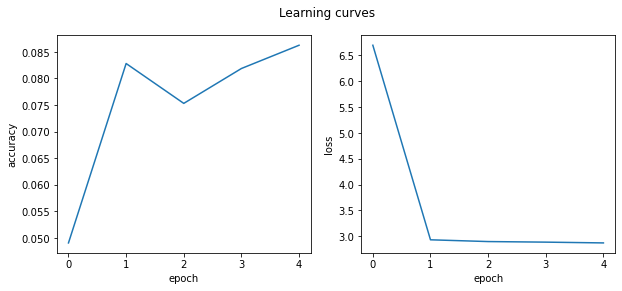

In [28]:
model_evaluate(ann, ann_hist, X_train_norm, X_test_norm, y_train, y_test)

## Convolutional Neural Network 

In [30]:
cnn = models.Sequential([
    layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(356, 356, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(20, activation='softmax')
])

cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

cnn_hist = cnn.fit(X_train_norm, y_train, epochs = 5)

Epoch 1/5
100/100 [==============================] - 148s 1s/step - loss: 3.4921 - accuracy: 0.0587
Epoch 2/5
100/100 [==============================] - 144s 1s/step - loss: 2.8904 - accuracy: 0.1153
Epoch 3/5
100/100 [==============================] - 165s 2s/step - loss: 2.7375 - accuracy: 0.1388
Epoch 4/5
100/100 [==============================] - 161s 2s/step - loss: 2.5751 - accuracy: 0.1928
Epoch 5/5
100/100 [==============================] - 162s 2s/step - loss: 2.3780 - accuracy: 0.2375


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###################### TRAIN SET ######################

               precision    recall  f1-score   support

           0       0.80      0.64      0.71       168
           1       0.33      0.87      0.48       165
           2       0.15      0.21      0.18       159
           3       0.00      0.00      0.00       152
           4       0.59      0.29      0.39       153
           5       0.49      0.32      0.38       157
           6       0.19      0.71      0.30       164
           7       0.00      0.00      0.00       157
           8       0.57      0.02      0.05       163
           9       0.21      0.03      0.06       156
          10       0.17      0.82      0.28       165
          11       0.19      0.05      0.08       156
          12       0.00      0.00      0.00       164
          13       0.52      0.16      0.24       165
          14       0.52      0.91      0.66       158
          15       0.11      0.06      0.08       161
          16       0.15

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###################### TEST SET ######################

               precision    recall  f1-score   support

           0       0.63      0.59      0.61        32
           1       0.17      0.66      0.27        35
           2       0.19      0.29      0.23        41
           3       0.00      0.00      0.00        48
           4       0.46      0.13      0.20        47
           5       0.59      0.37      0.46        43
           6       0.07      0.31      0.12        36
           7       0.00      0.00      0.00        43
           8       0.00      0.00      0.00        37
           9       0.14      0.02      0.04        44
          10       0.08      0.46      0.14        35
          11       0.00      0.00      0.00        44
          12       0.00      0.00      0.00        36
          13       0.50      0.03      0.05        35
          14       0.42      0.48      0.44        42
          15       0.13      0.10      0.11        39
          16       0.08 

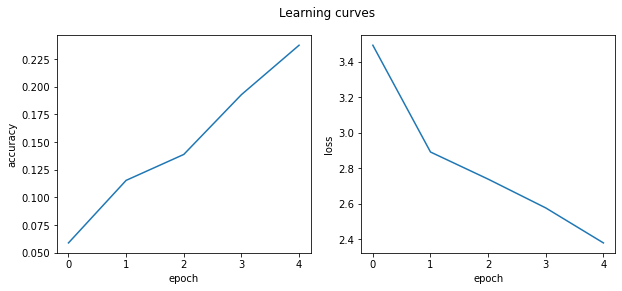

In [32]:
model_evaluate(cnn, cnn_hist, X_train_norm, X_test_norm, y_train, y_test)